In [183]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib widget

In [184]:
import numpy as np

In [185]:
dx = 0.2
Lx = 200

# nbr of cells
nx = int(Lx/dx)

nghost_cells = 1

p_psi = 1                     # primal physical start index
d_psi = 1                     # dual ...
d_pei = nghost_cells + nx-1   # dual physical end index
p_pei = nghost_cells + nx     # primal ....

# nbr of primal (p) and dual (d) nodes
nxp = nx + 1 + 2*nghost_cells  
nxd = nx + 2*nghost_cells

xd = dx * np.arange(nxd) - dx*0.5
xp = dx * np.arange(nxp) - dx

print(dx,Lx,nx)

0.2 200 1000


In [187]:


def deriv1_d2p(f):
    return (f[d_psi:d_pei+2] - f[d_psi-1:d_pei+1])/dx

def deriv1_p2d(f):
    return (f[p_psi+1:p_pei+1] - f[p_psi:p_pei])/dx

def fill_pghosts_periodic(f):
    f[p_psi-1] = f[p_pei-1]
    f[p_pei+1] = f[p_psi+1]
    
def fill_dghosts_periodic(f):
    f[d_psi-1] = f[d_pei]
    f[d_pei+1] = f[d_psi]
    
def p_domain():
    return np.arange(p_psi, p_pei+1)

def d_domain():
    return np.arange(d_psi, d_pei+1)

def p2d(f):
    return 0.5*(f[p_psi:p_pei+2]+f[p_psi-1:p_pei+1])

def d2p(f):
    d = np.zeros(nxp)
    d[p_domain()] =   0.5*(f[d_psi:d_pei+2]+f[d_psi-1:d_pei+1])
    fill_pghosts_periodic(d)
    return d

def is_periodic_p(f):
    return (f[p_pei] == f[p_psi]) and (f[p_pei-1] == f[p_psi-1]) and (f[p_pei+1] == f[p_psi+1])

In [323]:


def conserv(u, phi, dphi, num_flux, boundary_condition):
    f = num_flux(u, phi, dphi, boundary_condition)
    divF = (f[d_psi:d_pei+2]-f[d_psi-1:d_pei+1])
    u[p_domain()] += - divF *dt
    if boundary_condition == "periodic":
        fill_pghosts_periodic(u)
    else:
        raise RuntimeError("unsupported boundary condition")

## Initial condition

In [394]:
def initialize(init):
    u = np.zeros(nxp)
    if init == "sine":
        u[:] = np.sin(xp*2*np.pi/Lx)*0.2
    elif init=="square":
        u[:] = 0.5*(1+np.tanh((xp-Lx*0.4))) - 0.5*(1+np.tanh((xp-Lx*0.6)))
    else:
        raise RuntimeError("unsupported initial condition")
    u0 = np.copy(u)
    return u, u0

## Burger's equation

$\partial_t u  + u \partial_x u = 0$

which also writes:

$\partial_t u  + \frac{1}{2} \partial_x u^2 = 0$

so $\partial_t u  + \partial_x f = 0$ with $f = \frac{1}{2}u^2$

In [395]:
def burger_flux(u):
    return 0.5*u*u
def dburger_flux(u):
    return u

## advection equation

$\partial_t u + a\partial_x u = 0$

In [355]:
def adv_flux(u, a=0.5):
    return a*u
def dadv_flux(u,a=0.5):
    return a

## Methods

### Lax Friedrichs

In [ ]:
#example with nx=5 cells + 1 ghost cell on each side
#d_psi           1
#p_psi        1    
#d_pei                                   5
#p_pei                                      6
#border       |                             |
# prim  0     1     2     3     4     5     6
# dual     0     1     2     3     4     5     6
# tot   +  o  +  o  +  o  +  o  +  o  +  o  +  o  +

def LaxFriedrichs(u, phi, dphi, boundary_condition):
    fr = np.zeros(nxd)
    phi_d = p2d(phi(u))
    fr[d_psi:d_pei+2]   = phi_d[d_psi:d_pei+2]   - dx/dt*0.5*(u[p_psi+1:p_pei+2]-u[p_psi:p_pei+1])
    if boundary_condition == "periodic":
        fr[d_psi-1] = fr[d_pei]
    return fr#, fl

### WENO 3

- compute $\hat{f}^\pm(u_i)$ 
    - Lax-Friedrichs flux needs to compute $\frac{1}{2}\left(f(u_i) \pm \alpha u_i\right)$ with $\alpha = max |\partial_u f|$, the max is taken within the stencil (local) or globally on the grid
- compute $\hat{f}^+_{i+1/2} = w_1q_1 + w_2q_2$ 
    - $q_1 = \frac{1}{2}f^+(u_i) + \frac{1}{2}f^+(u_i)$
    - $q_2 = \frac{-1}{2}f^+(u_{i-1}) + \frac{3}{2}f^+(u_i)$
    - $w_k = \frac{\alpha_k}{\alpha_1 + \alpha_2}$
    - $\alpha_k = \frac{c_k}{\beta_k + \epsilon}$
    - $c_k = (1/3,2/3)$
    - $\epsilon=1e-6$
    - Liu2017 : 
        - $\beta_0 = \frac{1}{4}\left(|f_{i+1} - f_i| - |4f_i - 3 f_{i-1} - f_{i+1}|\right)^2$
        - $\beta_1 = \frac{1}{4}\left(|f_{i+1} - f_i| - |3f_{i+1} - f_{i-1} - 4f_{i}|\right)^2$
    - classic : 
        - $\beta_1 = (f_{i+1} - f{i})^2$
        - $\beta_1 = (f_{i} - f{i-1})^2$

In [387]:
def lf(u, phi, dphi):
    fi = phi(u)
    dfi = dphi(u)
    alpha = np.max(np.abs(dfi))
    return 0.5*fi + alpha*u, 0.5*fi - alpha*u

def weno(u, phi, dphi, boundary_condition):
    
    eps=1e-40
    
    fp,fm  = lf(u, phi, dphi)
    f_r   = np.zeros(nxd) 
    
    def weno_(u, f):
        f_ip1 = f[p_psi+1:p_pei+2]
        f_im1 = f[p_psi-1:p_pei]
        f_i   = f[p_domain()] 
        
        # liu2017  : https://onlinelibrary.wiley.com/doi/epdf/10.1002/fld.4480
        beta2 = 0.25*(np.abs(f_ip1 - f_im1) - np.abs(4*f_i - 3*f_im1 - f_ip1))**2
        beta1 = 0.25*(np.abs(f_ip1 - f_im1) - np.abs(3*f_ip1 + f_im1 - 4*f_i))**2
        
        # weno-JS 96
        #beta1 = (f_ip1-f_i)**2
        #beta2 = (f_i-f_im1)**2

        c1,c2 = 1/3,2/3

        alpha1 = c1/(beta1 + eps)**2
        alpha2 = c2/(beta2 + eps)**2
        
        w1 = alpha1/(alpha1 + alpha2)
        w2 = alpha2/(alpha1 + alpha2)

        q1 = 0.5*f_i + 0.5*f_ip1
        q2 = -0.5*f_im1 + 1.5*f_i
        
        fr = w1*q1 + w2*q2
        return fr
    
    # f^\pm_{i+1/2}
    fr_p = weno_(u,fp)
    fr_m = weno_(u,fm)
    
    if boundary_condition=="periodic":

        f_r[1:] = fr_p + fr_m
        f_r[0] = f_r[-2]
    return f_r

In [400]:
dt = 0.1
T = 2000
nt = int(T/dt)+1
times = np.arange(nt)*dt

udiagLF = np.zeros((nxp,nt))
udiagWENO = np.zeros((nxp,nt))
uLF,u0 = initialize("square")
uWENO,u0 = initialize("square")

for it,t in enumerate(times):
    conserv(uLF, adv_flux, dadv_flux, LaxFriedrichs, "periodic")
    conserv(uWENO, adv_flux, dadv_flux, weno, "periodic")
    udiagLF[:,it] = uLF
    udiagWENO[:,it] = uWENO
    

In [406]:
int(nt/2)

10000

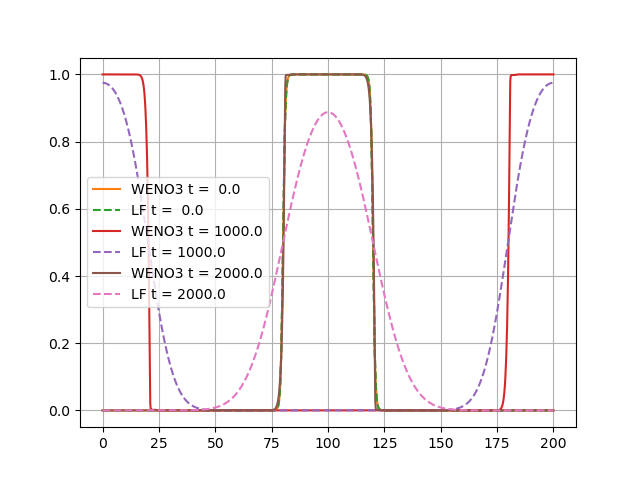

In [409]:
fig,ax = plt.subplots()
ax.plot(xp,u0,ls="--")
for itdiag in [0,int(nt/2),-1]:
    ax.plot(xp, udiagWENO[:,itdiag], label="WENO3 t = {:4.1f}".format(times[itdiag]))
    ax.plot(xp, udiagLF[:,itdiag], label="LF t = {:4.1f}".format(times[itdiag]), ls="--")
ax.grid()
ax.legend()

In [414]:
dt = 0.1
T = 500
nt = int(T/dt)+1
times = np.arange(nt)*dt

udiagLF = np.zeros((nxp,nt))
udiagWENO = np.zeros((nxp,nt))
uLF,u0 = initialize("square")
uWENO,u0 = initialize("square")

for it,t in enumerate(times):
    conserv(uLF, burger_flux, dburger_flux, LaxFriedrichs, "periodic")
    conserv(uWENO, burger_flux, dburger_flux, weno, "periodic")
    udiagLF[:,it] = uLF
    udiagWENO[:,it] = uWENO

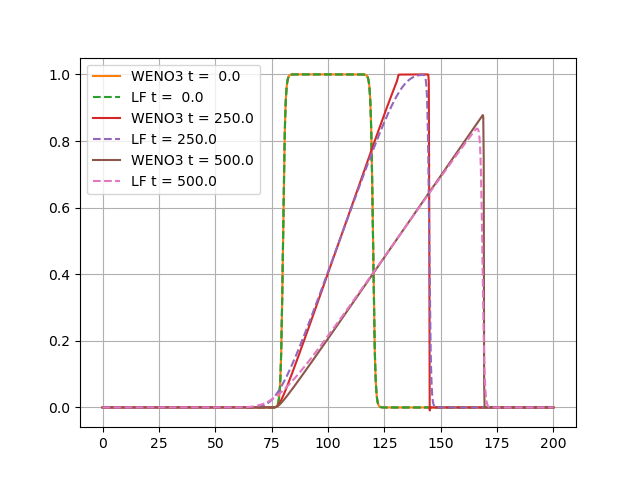

In [415]:
fig,ax = plt.subplots()
ax.plot(xp,u0,ls="--")
for itdiag in [0,int(nt/2),-1]:
    ax.plot(xp, udiagWENO[:,itdiag], label="WENO3 t = {:4.1f}".format(times[itdiag]))
    ax.plot(xp, udiagLF[:,itdiag], label="LF t = {:4.1f}".format(times[itdiag]), ls="--")
ax.grid()
ax.legend()